# Importing Libraries

In [35]:
import pandas as pd

# Load and explore data

In [36]:
df = pd.read_csv('data/data.csv',sep=';')

In [37]:
df.columns = df.columns.str.lower()

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 513530 entries, 0 to 513529
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   513530 non-null  int64  
 1   periodo              513530 non-null  int64  
 2   renaes               513530 non-null  int64  
 3   ipress               513386 non-null  object 
 4   departamento         497494 non-null  object 
 5   provincia            497494 non-null  object 
 6   distrito             497494 non-null  object 
 7   ubigeo               497494 non-null  float64
 8   codigo_diagnostico   513530 non-null  object 
 9   diagnosticos         513530 non-null  object 
 10  grupo_diagnosticos   513530 non-null  object 
 11  grupo_cobertura      513530 non-null  object 
 12  sexo                 513530 non-null  object 
 13  edad                 513530 non-null  int64  
 14  tipo_seguro          513530 non-null  object 
 15  codigo_servicio  

In [39]:
df.describe()

,id,periodo,renaes,ubigeo,edad,codigo_servicio,fecha_atencion,fecha_internamiento,fecha_alta
count,513530.000000,513530.000000,513530.000000,497494.000000,513530.000000,513530.000000,5.135300e+05,6.497700e+04,1.007040e+05
mean,26939.342498,202206.900393,7302.390519,139902.452050,51.407737,180.431089,2.021996e+07,2.021856e+07,2.021941e+07
std,15520.704405,3.401527,4321.126030,29374.599187,19.449887,293.328790,2.467575e+03,3.702343e+03,3.134600e+03
min,1.000000,202201.000000,1.000000,10101.000000,0.000000,56.000000,2.021071e+07,2.021011e+07,2.021082e+07
25%,13669.000000,202204.000000,6210.000000,150101.000000,42.000000,56.000000,2.022031e+07,2.022011e+07,2.022022e+07
50%,26139.000000,202207.000000,6210.000000,150141.000000,54.000000,56.000000,2.022061e+07,2.022032e+07,2.022052e+07
75%,40655.000000,202210.000000,7277.000000,150141.000000,65.000000,71.000000,2.022091e+07,2.022051e+07,2.022082e+07
max,52598.000000,202212.000000,28025.000000,250105.000000,104.000000,910.000000,2.022123e+07,2.022122e+07,2.022123e+07


# Cleaning Data

In [41]:
df['fecha_atencion'] = pd.to_datetime(df['fecha_atencion'],format='%Y%m%d')

In [42]:
df.columns
df.drop(columns=['renaes','ipress','provincia',	'distrito',	'ubigeo','codigo_servicio', 'fecha_internamiento', 'fecha_alta', 'monto_bruto','grupo_cobertura','periodo','codigo_diagnostico','diagnosticos'],inplace=True)

# Modeling

## Situation 1: Service Type Classification

* Predict the type of service required (e.g., "Outpatient Consultation", "Teleguidance") based on patient characteristics (department, diagnosis, sex, age, type of insurance).

* This situation can help to predict what type of care is most likely for different patient profiles, which can be useful for allocating resources and staff in health institutions.

### Functions

In [43]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

classification_metrics = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

def save_metrics(model, y_test, predictions, average='binary'):
    global classification_metrics

    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average=average)
    recall = recall_score(y_test, predictions, average=average)
    f1 = f1_score(y_test, predictions, average=average)

    new_row = {
        'Model': model,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

    classification_metrics = pd.concat([classification_metrics, pd.DataFrame([new_row])], ignore_index=True)
    classification_metrics = classification_metrics.dropna(axis=1, how='all')

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def display_confusion_matrix(y_test, y_pred, labels=None, cmap="Blues"):
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=cmap, ax=ax)
    if labels is not None:
        plt.setp(ax.get_xticklabels(), rotation=10)
        plt.setp(ax.get_yticklabels(), rotation=10)
    plt.title('Confusion Matrix')
    plt.show()

### Random Forest Classificator

In [45]:
df_1 = df.copy()
df_1 = df_1.drop(columns=['fecha_atencion'])

In [46]:
servicios = []
for servicio, valor in df_1['servicio'].value_counts().items():
    if valor>0.05*len(df_1):
        servicios.append(servicio)

In [47]:
df_1 =  df_1[df_1['servicio'].map(lambda x: x in servicios)]

In [48]:
from sklearn.preprocessing import LabelEncoder

obj_cols = df_1.select_dtypes('object').columns

label_encoders = {}

for col in obj_cols:
    le = LabelEncoder()
    df_1[col] = le.fit_transform(df_1[col])
    label_encoders[col] = le

In [49]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df_1.drop(columns=['servicio']),df_1['servicio'],test_size=0.20)

In [50]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=150,criterion='gini',max_depth=15,min_samples_split=50,class_weight='balanced')
rfc.fit(x_train,y_train)
y_pred_1 = rfc.predict(x_test)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_15492\308329166.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  classification_metrics = pd.concat([classification_metrics, pd.DataFrame([new_row])], ignore_index=True)


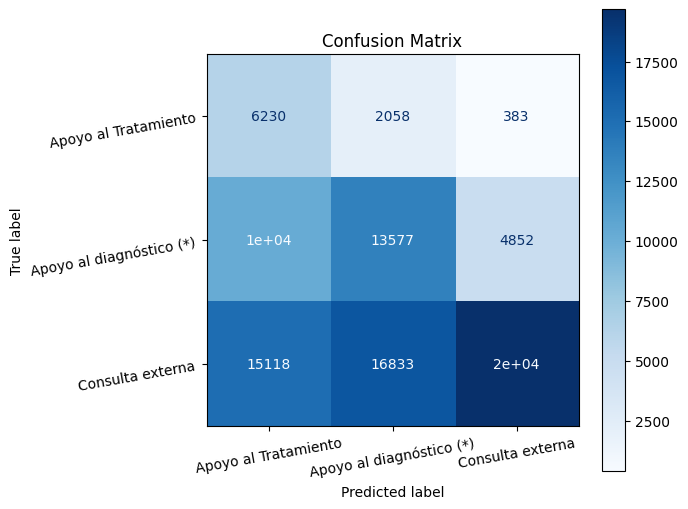

In [51]:
save_metrics(rfc.__class__.__name__, y_test, y_pred_1, average='weighted')
display_confusion_matrix(y_test, y_pred_1, labels=label_encoders['servicio'].classes_, cmap="Blues")

### Logistic Regression

In [52]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(class_weight='balanced',solver='newton-cg')
lr.fit(x_train,y_train)
y_pred_2 = lr.predict(x_test)

g:\Data-Mining-UNAM\.venv\Lib\site-packages\scipy\optimize\_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
g:\Data-Mining-UNAM\.venv\Lib\site-packages\sklearn\utils\optimize.py:99: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(


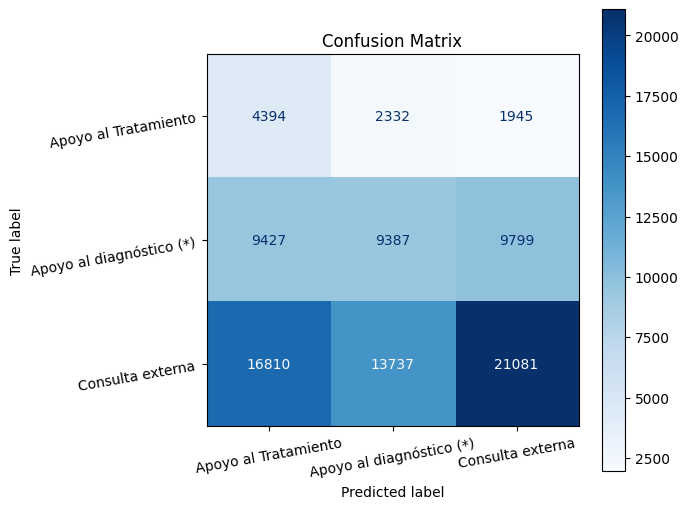

In [53]:
save_metrics(lr.__class__.__name__, y_test, y_pred_2, average='weighted')
display_confusion_matrix(y_test, y_pred_2, labels=label_encoders['servicio'].classes_, cmap="Blues")

### Naive Bayes

In [54]:
from sklearn.naive_bayes import ComplementNB

cnb = ComplementNB(class_prior=[0.2,0.3,0.5])
cnb.fit(x_train,y_train)
y_pred_3 = cnb.predict(x_test)

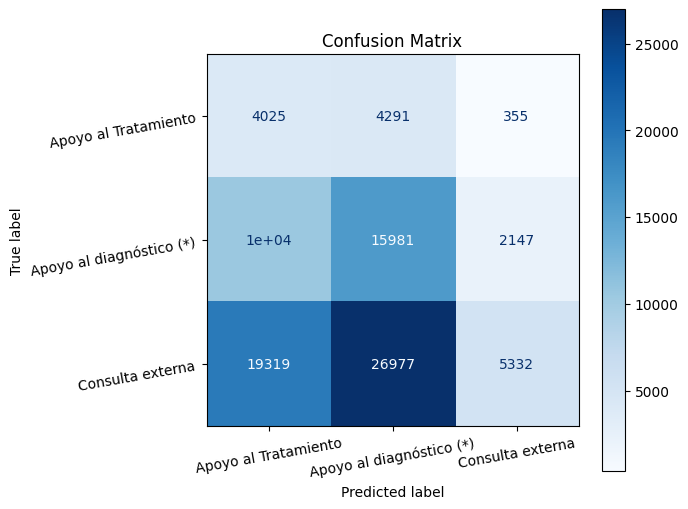

In [55]:
save_metrics(cnb.__class__.__name__, y_test, y_pred_3, average='weighted')
display_confusion_matrix(y_test, y_pred_3, labels=label_encoders['servicio'].classes_, cmap="Blues")

### CategoricalNB

In [56]:
from sklearn.naive_bayes import CategoricalNB

catnb = CategoricalNB()
catnb.fit(x_train,y_train)
y_pred_4 = catnb.predict(x_test)

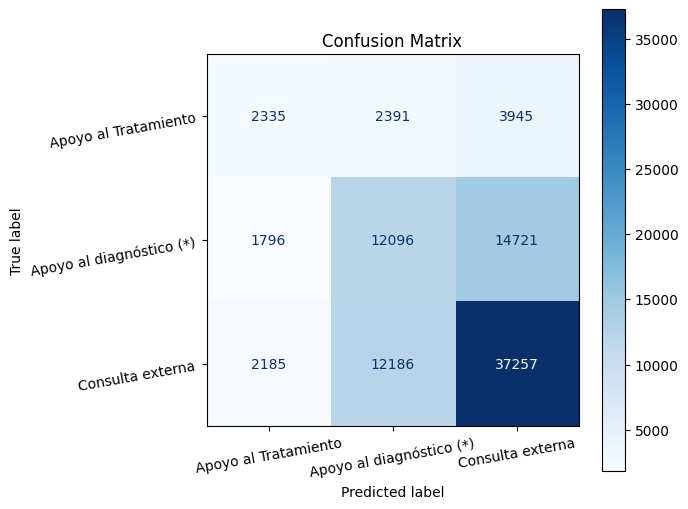

In [57]:
save_metrics(catnb.__class__.__name__, y_test, y_pred_4, average='weighted')
display_confusion_matrix(y_test, y_pred_4, labels=label_encoders['servicio'].classes_, cmap="Blues")

### Decision Tree Classifier

In [58]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(criterion='entropy',min_samples_split=30,max_depth=45,class_weight='balanced')
dtc.fit(x_train,y_train)
y_pred_5 = dtc.predict(x_test)

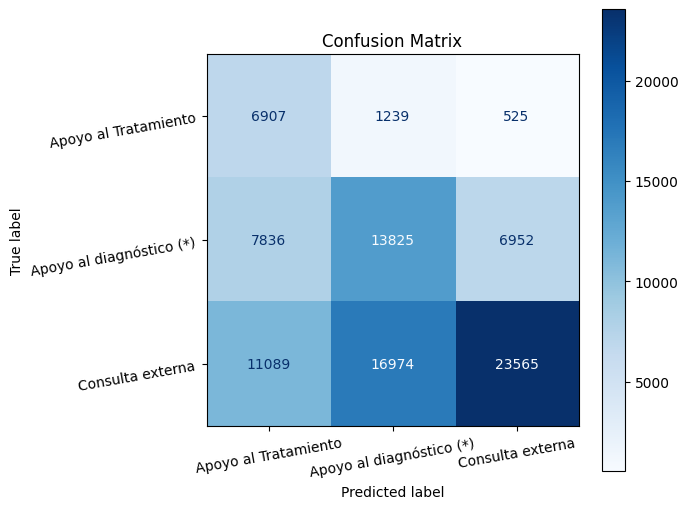

In [59]:
save_metrics(dtc.__class__.__name__, y_test, y_pred_5, average='weighted')
display_confusion_matrix(y_test, y_pred_5, labels=label_encoders['servicio'].classes_, cmap="Blues")

In [60]:
classification_metrics

,Model,Accuracy,Precision,Recall,F1 Score
0,RandomForestClassifier,0.444080,0.612483,0.444080,0.471845
1,LogisticRegression,0.392096,0.505576,0.392096,0.423436
2,ComplementNB,0.284978,0.515663,0.284978,0.258195
3,CategoricalNB,0.581339,0.568843,0.581339,0.573506
4,DecisionTreeClassifier,0.498212,0.605745,0.498212,0.516791


### Conclusion

CategoricalNB would be the best choice here, as it shows a solid balance between precision and recall, with the highest F1 score and accuracy among the models. This suggests that it manages to correctly capture both positives and negatives with less trade-off, being more reliable for balanced classifications.

## Situation 2: Patient Segmentation Analysis

In [61]:
from sklearn.cluster import KMeans

def elbow_method(X):
    inertia = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)
    plt.plot(range(1, 11), inertia, marker='o')
    plt.title('Elbow Method')
    plt.xlabel('# of Clusters')
    plt.ylabel('inertia')
    plt.show()


In [62]:
df_2 = df_1.drop(columns='id').copy()

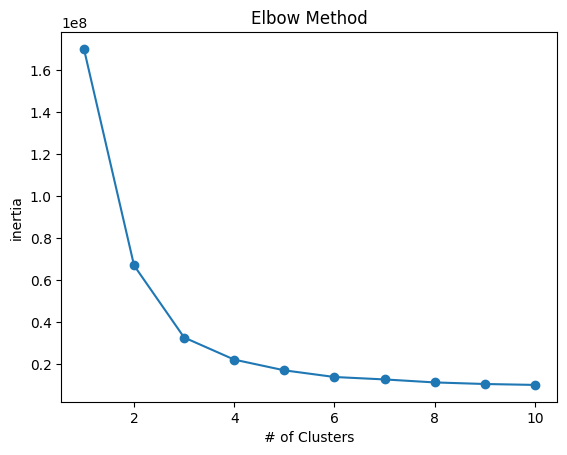

In [63]:
elbow_method(df_2)

In [64]:
# Elegir el número de clusters
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_2)

# Agregar etiquetas de cluster al DataFrame
df_2['cluster'] = kmeans.labels_


In [65]:
# Agrupa los datos por los clusters asignados
clusters_summary = df_2.groupby('cluster').median()  # Puedes usar `.median()` o `.describe()`

In [66]:
servicio_dict = {}
for i,label in enumerate(label_encoders['servicio'].classes_):
    servicio_dict[i] = label

grupo_diag = {}
for i,label in enumerate(label_encoders['grupo_diagnosticos'].classes_):
    grupo_diag[i] = label
    
depart_dict = {}
for i,label in enumerate(label_encoders['departamento'].classes_):
    depart_dict[i] = label
    
sexo_dict = {}
for i,label in enumerate(label_encoders['sexo'].classes_):
    sexo_dict[i] = label

tipo_seguro_dict = {}
for i,label in enumerate(label_encoders['tipo_seguro'].classes_):
    tipo_seguro_dict[i] = label

In [67]:
clusters_summary['servicio'] = clusters_summary['servicio'].map(servicio_dict)
clusters_summary['grupo_diagnosticos'] = clusters_summary['grupo_diagnosticos'].map(grupo_diag)
clusters_summary['departamento'] = clusters_summary['departamento'].map(depart_dict)
clusters_summary['sexo'] = clusters_summary['sexo'].map(sexo_dict)
clusters_summary['tipo_seguro'] = clusters_summary['tipo_seguro'].map(tipo_seguro_dict)

In [68]:
clusters_summary

,departamento,grupo_diagnosticos,sexo,edad,tipo_seguro,servicio
cluster,,,,,,
0,Lima,CANCER DE MAMA,FEMENINO,72.0,SIS GRATUITO,Consulta externa
1,Lima,LEUCEMIA,MASCULINO,12.0,SIS GRATUITO,Consulta externa
2,Lima,CANCER DE MAMA,FEMENINO,56.0,SIS GRATUITO,Consulta externa
3,Lima,CANCER DE MAMA,FEMENINO,42.0,SIS GRATUITO,Consulta externa


In [69]:
# from sklearn.cluster import DBSCAN

# dbscan = DBSCAN(eps=2, min_samples=300)  # Ajusta eps y min_samples según el dataset
# dbscan.fit(df_2)

# # Agregar etiquetas de clúster al DataFrame
# df_2['cluster'] = dbscan.labels_

## Situation 3: Time series to analyze the trend of care based on date

In [70]:
df_3 = df[['fecha_atencion','id']]
df_3 = df_3[df_3['fecha_atencion'].dt.year==2022]
df_3 = df_3.groupby('fecha_atencion').size()
df_3 = pd.DataFrame(df_3)
df_3.columns = ['cantidad']

In [71]:
# Rellenar fechas faltantes con 0
df_3 = df_3.asfreq('D', fill_value=0)
df_3= df_3.resample('ME').sum()

In [72]:
df_3 = df_3.iloc[:-1,:]

In [73]:
from statsmodels.tsa.arima.model import ARIMA

def AIC(data):
# Comparar diferentes combinaciones de p, d, q
    aic_values = []
    for p in range(0, 3):  # Cambia el rango según sea necesario
        for d in range(0, 3):
            for q in range(0, 3):
                try:
                    model = ARIMA(data['cantidad'], order=(p, d, q))
                    model_fit = model.fit()
                    aic_values.append((p, d, q, model_fit.aic))
                except:
                    continue

    # Crear un DataFrame para visualizar los resultados
    aic_df = pd.DataFrame(aic_values, columns=['p', 'd', 'q', 'AIC'])
    sorted_aic_df = aic_df.sort_values('AIC').reset_index(drop=True)
    print(sorted_aic_df)
    p,d,q = sorted_aic_df.iloc[0,0:3].values
    return p,d,q

In [74]:
AIC(df_3)

g:\Data-Mining-UNAM\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
g:\Data-Mining-UNAM\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
g:\Data-Mining-UNAM\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
g:\Data-Mining-UNAM\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
g:\Data-Mining-UNAM\.venv\Lib\site-packages\statsmodels\tsa\

    p  d  q           AIC
0   2  2  0  1.819429e+02
1   1  2  1  1.819601e+02
2   2  2  1  1.825760e+02
3   1  2  0  1.827739e+02
4   0  2  1  1.840719e+02
5   0  2  0  1.849371e+02
6   0  2  2  1.930694e+02
7   0  1  0  1.973746e+02
8   2  1  0  1.978507e+02
9   0  1  2  1.985792e+02
10  2  1  1  1.988756e+02
11  1  1  0  1.993848e+02
12  0  1  1  1.998134e+02
13  1  1  1  1.999363e+02
14  1  1  2  1.999621e+02
15  0  0  0  2.175259e+02
16  0  0  1  2.179527e+02
17  1  0  0  2.182603e+02
18  1  0  1  2.194622e+02
19  0  0  2  2.198616e+02
20  2  0  0  2.199703e+02
21  2  0  1  2.203183e+02
22  2  0  2  2.204217e+02
23  1  0  2  2.211822e+02
24  2  2  2  7.042823e+03
25  1  2  2  2.265698e+04
26  2  1  2  1.181208e+12


(np.float64(2.0), np.float64(2.0), np.float64(0.0))

In [75]:

# Configura los parámetros (p, d, q) según el análisis de tu serie de tiempo
p, d, q = 2,0,1  # Este es un ejemplo, pueden ajustarse tras la evaluación de la serie

# Crear y ajustar el modelo ARIMA
model = ARIMA(df_3['cantidad'], order=(p, d, q))
arima_result = model.fit()

In [76]:
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:               cantidad   No. Observations:                   11
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -105.159
Date:                Tue, 12 Nov 2024   AIC                            220.318
Time:                        02:57:08   BIC                            222.308
Sample:                    01-31-2022   HQIC                           219.064
                         - 11-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.207e+04   1198.302     35.106      0.000    3.97e+04    4.44e+04
ar.L1          1.3113      0.326      4.022      0.000       0.672       1.950
ar.L2         -0.6146      0.317     -1.940      0.0

In [77]:
# Predicción para los próximos 10 días
forecast = arima_result.forecast(steps=4)

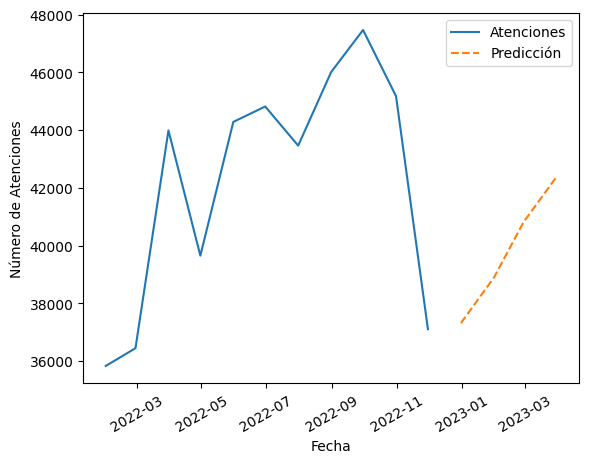

In [78]:
import matplotlib.pyplot as plt

# Graficar la serie original
plt.plot(df_3.index, df_3['cantidad'], label='Atenciones')

# Graficar la predicción
plt.plot(forecast.index, forecast, label='Predicción', linestyle='--')

plt.xlabel('Fecha')
plt.ylabel('Número de Atenciones')
plt.xticks(rotation=30)
plt.legend()
plt.show()


In [79]:
forecast

2022-12-31    37312.117794
2023-01-31    38884.802016
2023-02-28    40816.708587
2023-03-31    42383.451564
Freq: ME, Name: predicted_mean, dtype: float64